# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Generating-synthetic-data" data-toc-modified-id="Generating-synthetic-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Generating synthetic data</a></div><div class="lev1 toc-item"><a href="#Line-fitting-using-Bayes'-theorem" data-toc-modified-id="Line-fitting-using-Bayes'-theorem-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Line fitting using Bayes' theorem</a></div><div class="lev1 toc-item"><a href="#Quantifying-the-probability-of-a-fixed-model:" data-toc-modified-id="Quantifying-the-probability-of-a-fixed-model:-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Quantifying the probability of a fixed model:</a></div><div class="lev1 toc-item"><a href="#Selecting-between-two-models" data-toc-modified-id="Selecting-between-two-models-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Selecting between two models</a></div><div class="lev2 toc-item"><a href="#Different-datasets-will-prefer-different-models" data-toc-modified-id="Different-datasets-will-prefer-different-models-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Different datasets will prefer different models</a></div><div class="lev2 toc-item"><a href="#Yet-a-different-set" data-toc-modified-id="Yet-a-different-set-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Yet a different set</a></div><div class="lev1 toc-item"><a href="#The-larger-the-dataset,-the-more-resolving-power" data-toc-modified-id="The-larger-the-dataset,-the-more-resolving-power-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>The larger the dataset, the more resolving power</a></div>

Welcome to our primer on Bayesian Model Selection. 

As always, we begin by loading our required libraries.

In [1]:
# important stuff:
import os
import pandas as pd
import numpy as np
import statsmodels.tools.numdiff as smnd
import scipy

# Graphics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

# Magic function to make matplotlib inline;
# other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline. 
# There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

# Generating synthetic data

First, we will generate the data. We will pick evenly spaced x-values. The y-values will be picked according to the equation $y=-\frac{1}{2}x$ but we will add Gaussian noise to each point. Each y-coordinate will have an associated error. The size of the error bar will be selected randomly.

After we have picked the data, we will plot it to visualize it. It looks like a fairly straight line.

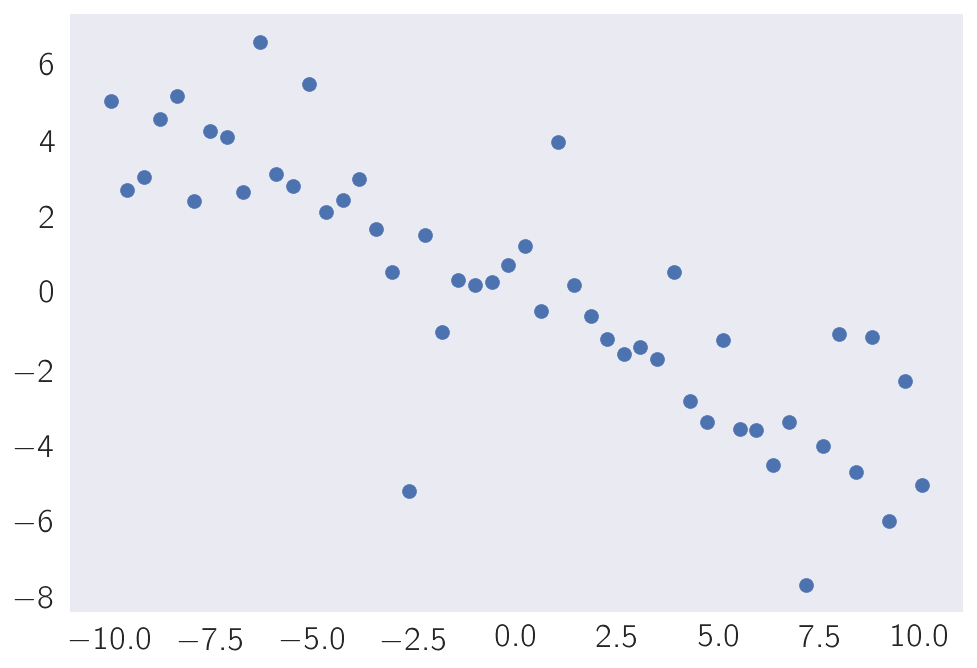

In [2]:
n = 50  # number of data points
x = np.linspace(-10, 10, n)
yerr = np.abs(np.random.normal(0, 2, n))
y = np.linspace(5, -5, n) + np.random.normal(0, yerr, n)
plt.scatter(x, y)

# Line fitting using Bayes' theorem

Now that we have generated our data, we would like to find the line of best fit given our data. To do this, we will perform a Bayesian regression. Briefly, Bayes equation is,

$$
P(X|D) \propto P(D|X)P(X).
$$

In other words, the probability of the model given the data is proportional to the probability of the data given the model times the probability of the model. 

Some necessary nomenclature at this point:
 * $P(D|X)\cdot P(X)$ is called the posterior probability
 * $P(X)$ is called the prior
 * $P(D|X)$ is called the likelihood
 

I claim that a functional form that will allow me to fit a line through this data is:

$$
P(X|D) \propto e^{\frac{(y_{Obs} - \alpha x)^2}{2\sigma_{Obs}^2}}\cdot (1 + \alpha^2)^{3/2}
$$

The first term in the equation measures the deviation between the observed y-coordinates and the predicted y-coordinates from a theoretical linear model, where $\alpha$ remains to be determined. We weight the result by the observed error, $sigma_{Obs}$. Then, we multiply by a prior that tells us what values of $\alpha$ should be considered. How to pick a good prior is somewhat difficult and a bit of an artform. One way is to pick a prior that is uninformative for a given parameter. In this case, we want to make sure that we sample slopes between [0,1] as densely as we sample [1,$\infty$]. For a more thorough derivation and explanation, please see [this excellent blog post](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/) by Jake Vanderplas.

The likelihood is the first term, and the prior is the second. We code it up in the next functions, with a minor difference. It is often computationally much more tractable to compute the natural logarithm of the posterior, and we do so here. 

We can now use this equation to find the model we are looking for. How? Well, the equation above basically tells us what model is most likely given that data and the prior information on the model. If we maximize the probability of the model, whatever parameter combination can satisfy that is a model that we are interested in!

In [3]:
# bayes model fitting:
def log_prior(theta):
    beta = theta
    return -1.5 * np.log(1 + beta ** 2)

def log_likelihood(beta, x, y, yerr):
    sigma = yerr
    y_model = beta * x
    return -0.5 * np.sum(np.log(2 * np.pi * sigma ** 2) + (y - y_model) ** 2 / sigma ** 2)

def log_posterior(theta, x, y, yerr):
    return log_prior(theta) + log_likelihood(theta, x, y, yerr)

def neg_log_prob_free(theta, x, y, yerr):
    return -log_posterior(theta, x, y, yerr)

Specificity is necessary for credibility. Let's show that by optimizing the posterior function, we can fit a line.

We optimize the line by using the function `scipy.optimize.minimize`. However, minimizing the logarithm of the posterior does not achieve anything! We are looking for the place at which the equation we derived above is maximal. That's OK. We will simply multiply the logarithm of the posterior by -1 and minimize that.

The probability of this model is 1.3e-32
The optimized probability is -0.5005x


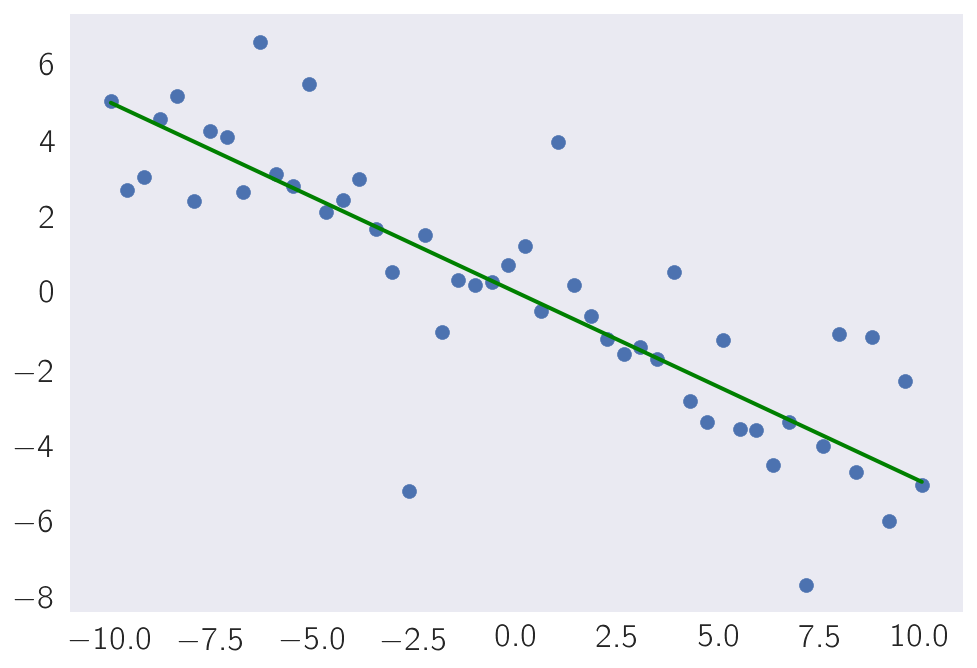

In [4]:
# calculate probability of free model:
res = scipy.optimize.minimize(neg_log_prob_free, 0, args=(x, y, yerr), method='Powell')

plt.scatter(x, y)
plt.plot(x, x*res.x, '-', color='g')
print('The probability of this model is {0:.2g}'.format(np.exp(log_posterior(res.x, x, y, yerr))))
print('The optimized probability is {0:.4g}x'.format(np.float64(res.x)))

We can see that the model is very close to the model we drew the data from. It works! 

However, the probability of this model is not very large. Why? Well, that's because the posterior probability is spread out over a large number of parameters. Bayesians like to think that a parameter is actually a number plus or minutes some jitter. Therefore, the probability of the parameter being exactly one number is usually smaller the larger the jitter. In thise case, the jitter is not terribly a lot, but the probability of this one parameter being exactly -0.5005 is quite low, even though it is the best guess for the slope given the data. 

# Quantifying the probability of a fixed model:

Suppose now that we had a powerful theoretical tool that allowed us to make a very, very good guess as to what line the points should fall on. Suppose this powerful theory now tells us that the line should be:

$$
y = -\frac{1}{2}x.
$$

Using Bayes' theorem, we could quantify the probability that the model is correct, given the data. Now, the prior is simply going to be 1 when the slope is -0.5, and 0 otherwise. This makes the equation to be fit:

$$
P(X|D) \propto exp({-\frac{(y_{Obs} + 0.5x)^2}{2\sigma_{Obs}}})
$$

In [5]:
# bayes model fitting:
def log_likelihood_fixed(x, y, yerr):
    sigma = yerr
    y_model = -1/2*x

    return -0.5 * np.sum(np.log(2 * np.pi * sigma ** 2) + (y - y_model) ** 2 / sigma ** 2)

def log_posterior_fixed(x, y, yerr):
    return log_likelihood_fixed(x, y, yerr)

The probability of this model is 1.9e-32


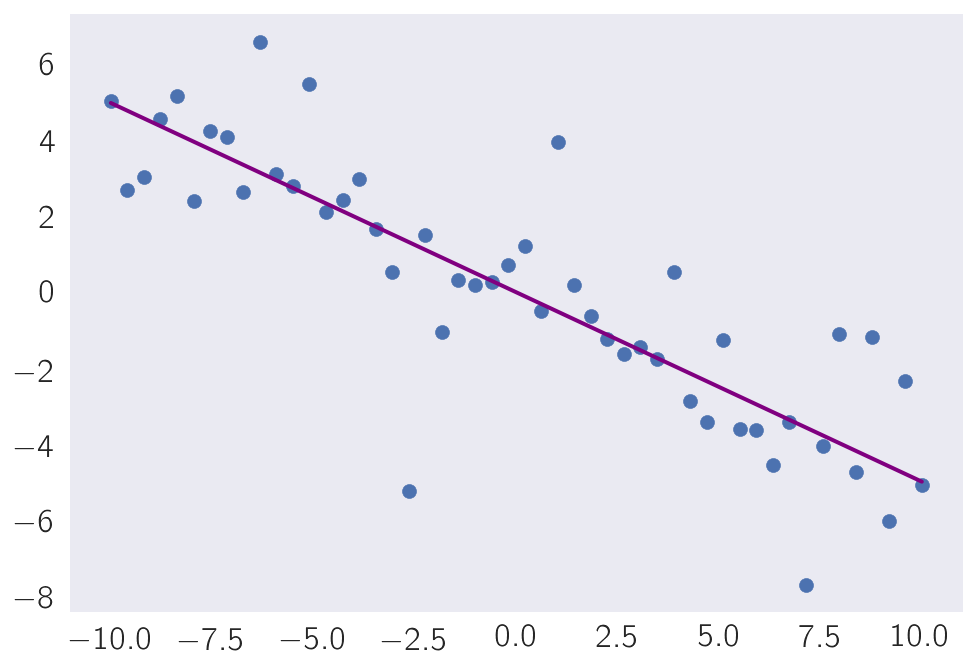

In [6]:
plt.scatter(x, y)
plt.plot(x, -0.5*x, '-', color='purple')
print('The probability of this model is {0:.2g}'.format(np.exp(log_posterior_fixed(x, y, yerr))))

We can see that the probability of this model is very similar to the probability of the alternative model we fit above. How can we pick which one to use?

# Selecting between two models

In [35]:
def model_selection(X, Y, Yerr, **kwargs):
    guess = kwargs.pop('guess', -0.5)

    # calculate probability of free model:
    res = scipy.optimize.minimize(neg_log_prob_free, guess, args=(X, Y, Yerr), method='Powell')
    
    # Compute error bars
    second_derivative = scipy.misc.derivative(log_posterior, res.x, dx=1.0, n=2, args=(X, Y, Yerr), order=3)
    cov_free = -1/second_derivative
    alpha_free = np.float64(res.x)
    log_free = log_posterior(alpha_free, X, Y, Yerr)
    
    # log goodness of fit for fixed models
    log_MAP = log_posterior_fixed(X, Y, Yerr)

    good_fit = log_free - log_MAP

    # occam factor - only the free model has a penalty
    log_occam_factor =(-np.log(2 * np.pi) + np.log(cov_free)) / 2
        
    # give more standing to simpler models. but just a little bit!
    lg = log_free - log_MAP + log_occam_factor - 2
    return lg

In [36]:
model_selection(x, y, yerr)

-15.0266763294


644.79045102510361

## Different datasets will prefer different models

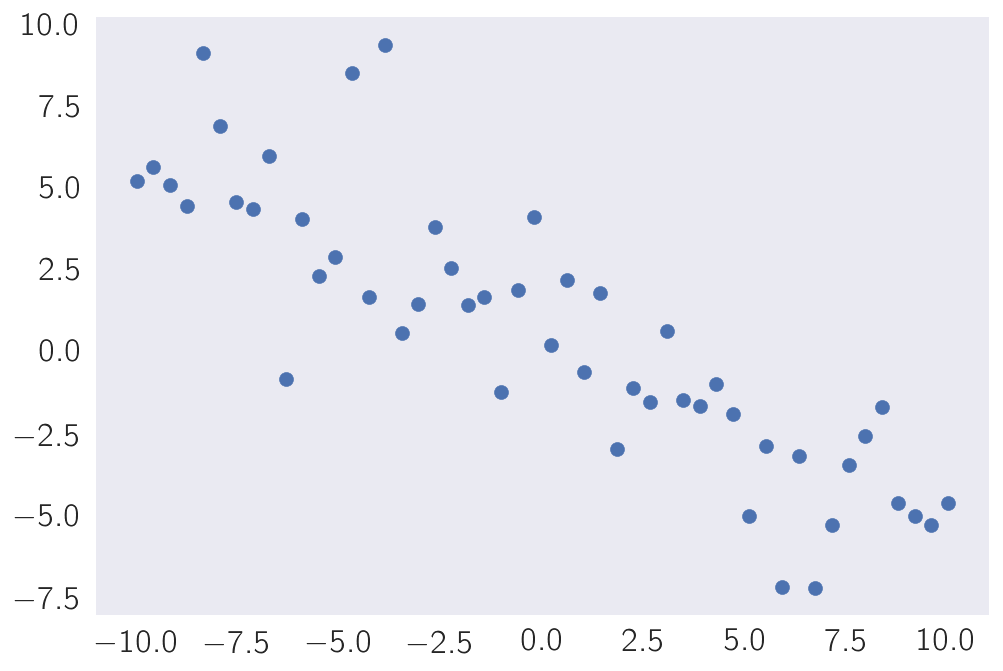

In [9]:
n = 50  # number of data points
x = np.linspace(-10, 10, n)
yerr = np.abs(np.random.normal(0, 2, n))
y = x*-0.55 + np.random.normal(0, yerr, n)
plt.scatter(x, y)

In [10]:
model_selection(x, y, yerr)

-5.6104738708042206

## Yet a different set

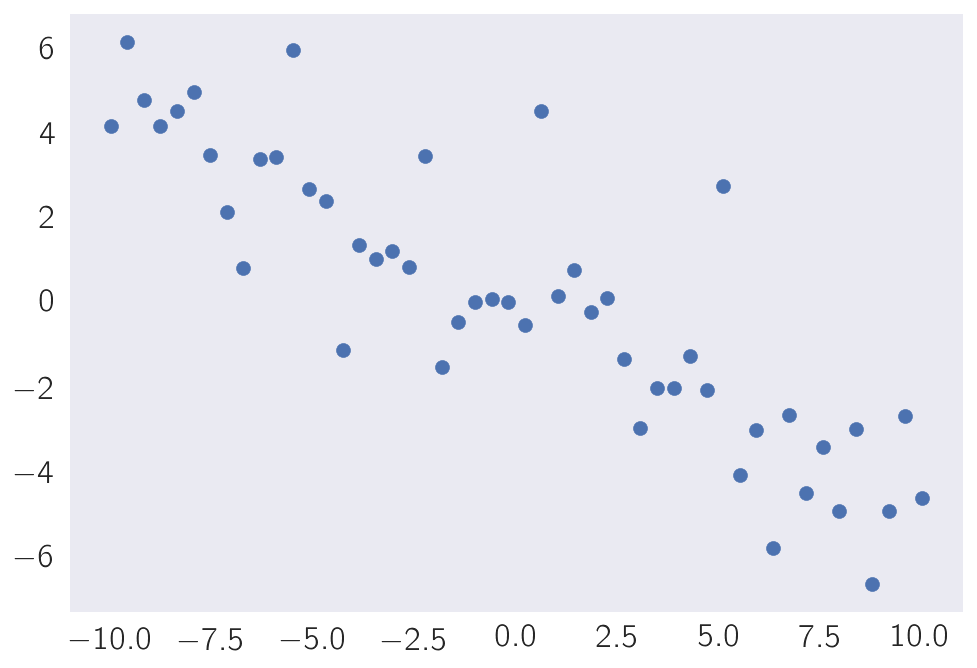

In [11]:
n = 50  # number of data points
x = np.linspace(-10, 10, n)
yerr = np.abs(np.random.normal(0, 2, n))
y = x*-0.52 + np.random.normal(0, yerr, n)
plt.scatter(x, y)

In [12]:
model_selection(x, y, yerr)

644.79045102510361

# The larger the dataset, the more resolving power

In [28]:
def simulate_many_odds_ratios(n):
    """
    Given a number `n` of data points, simulate 1,000 data points drawn from a null model and an alternative model and
    compare the odds ratio for each.
    """
    iters = 1000
    lg1 = np.zeros(iters)
    lg2 = np.zeros(iters)

    for i in range(iters):
        x = np.linspace(-10, 10, n)
        yerr = np.abs(np.random.normal(0, 2, n))

        # simulate two models: only one matches the fixed model
        y1 = -0.5*x + np.random.normal(0, yerr, n)
        y2 = -0.46*x + np.random.normal(0, yerr, n)

        lg1[i] = model_selection(x, y1, yerr)
        
        m2 = model_selection(x, y2, yerr)
        # Truncate OR for ease of plotting
        if m2 < 10:
            lg2[i] = m2
        else:
            lg2[i] = 10
            
    return lg1, lg2

In [29]:
def make_figures(n):
    lg1, lg2 = simulate_many_odds_ratios(n)
    
    lg1 = np.sort(lg1)
    lg2 = np.sort(lg2)
    
    fifty_point1 = lg1[int(np.floor(len(lg1)/2))]
    fifty_point2 = lg2[int(np.floor(len(lg2)/2))]
    
    fig, ax = plt.subplots(ncols=2, figsize=(15, 7), sharey=True)
    fig.suptitle('Log Odds Ratio for n={0} data points'.format(n), fontsize=20)
    sns.kdeplot(lg1, label='slope=-0.5', ax=ax[0], cumulative=False)
    ax[0].axvline(x=fifty_point1, ls='--', color='k')
    ax[0].set_title('Data drawn from null model')
    ax[0].set_ylabel('Density')

    sns.kdeplot(lg2, label='slope=-0.46', ax=ax[1], cumulative=False)
    ax[1].axvline(x=fifty_point2, ls='--', color='k')
    ax[1].set_title('Data drawn from alternative model')
    fig.text(0.5, 0.04, 'Log Odds Ratio', ha='center', size=18)

    return fig, ax

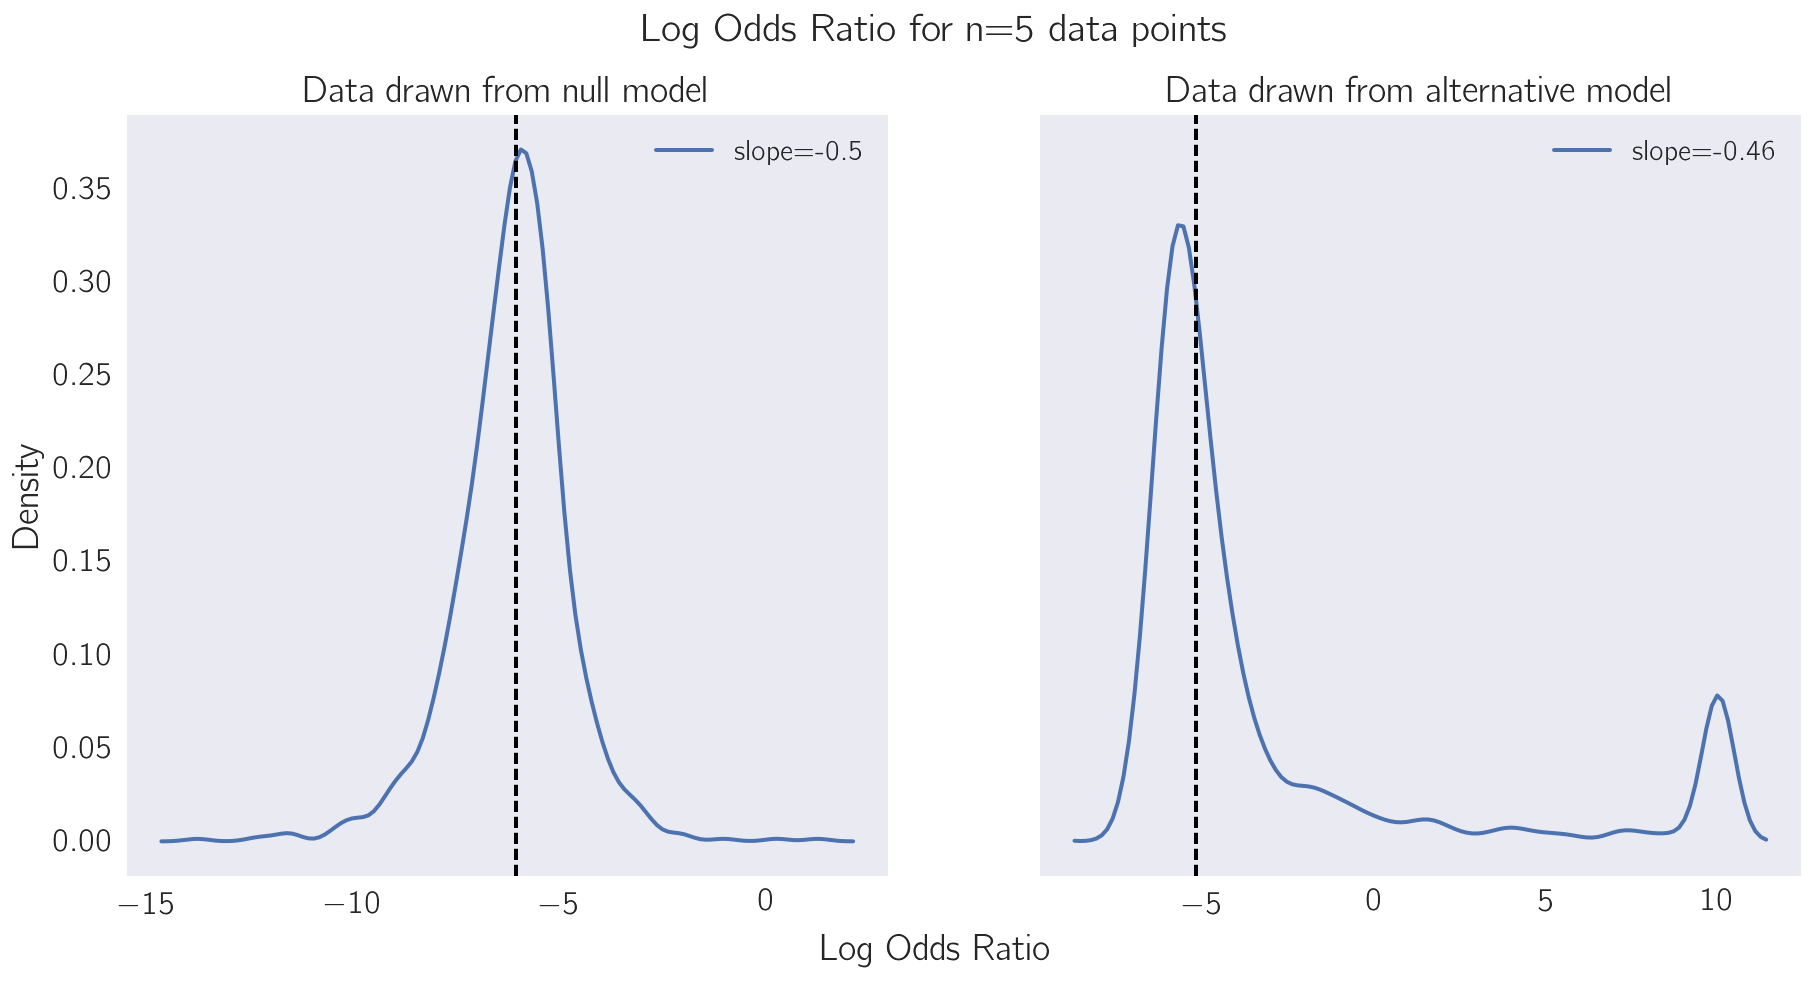

In [30]:
fig, ax = make_figures(n=5)

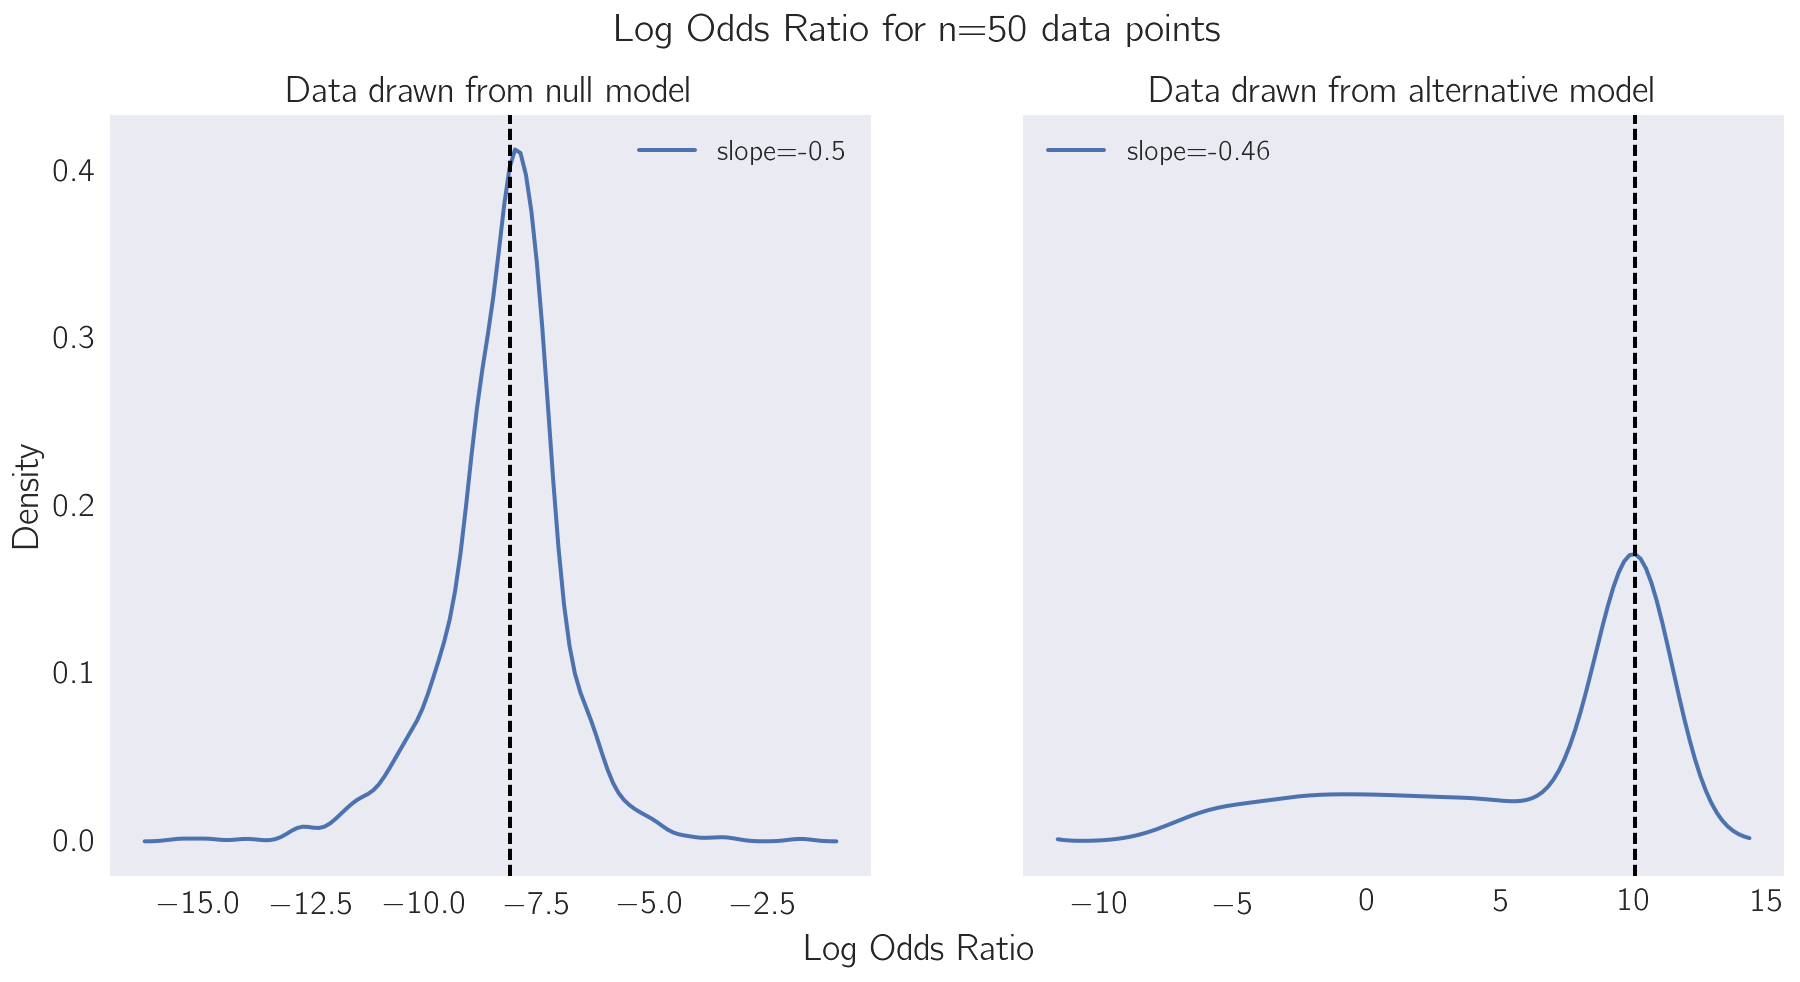

In [31]:
fig, ax = make_figures(n=50)